# Flight Arrival Delay Predicition System
*Challenge for Startup.ML*

### 1. Problem
Use the US Dept. of Transportation on-time arrival data for non-stop domestic flights by major air carriers to predict arrival delays.
This is a binary-classification model that predicts whether the arrival of the plane will be delayed (15 min or more) or not.
Set up.

In [85]:
""" Author: Genevieve Tran"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from scipy.stats import pearsonr
from datetime import datetime, date
import pickle 
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
%matplotlib inline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score


### 2. Data
#### 2.1 Loading the data
Downloading a year worth of data and put them in the data folder. Using this data I build up the Pandas DataFrame object.

In [ ]:
data = pd.DataFrame()
list_ = []
for file in listdir('flights_data'):
    if file != '.DS_Store':
        start = datetime.now()
        df = pd.read_csv('flights_data/{}'.format(file), index_col=None, header=0, low_memory=False)
        list_.append(df)
        del df
        print("Ended loading " + file[28:] + " time : " + str(datetime.now() - start))

In [34]:
print("Starting concatentaion...")
s = datetime.now()
df = pd.concat(list_, ignore_index=True)
print("Finished concatenating, took: " + str(datetime.now() - s))

Starting concatentaion...
Finished concatenating, took: 0:00:27.049187


#### 2.2 Manual Feature Production
After reading up on similar problems online there are 2 features I want to add to the dataset.
1. Weather Indicator variable at the destination airport
This is a feature that depends on the weather status of the arriving airport which can be interpreted from the number of flights cancelled at that airport with cancellation code B
2. Days to the closest national holiday
These are helpful indicators of whether a flight will be delayed or not

In [ ]:
cf = df.groupby(['FlightDate', 'Origin', 'CancellationCode'], as_index=False).aggregate(np.sum)
cf = cf[cf['CancellationCode'] == 'B'][['FlightDate', 'Origin', 'Cancelled']]
cf.rename(columns={'Origin': 'Dest', 'Cancelled': 'Weather'}, inplace=True)

In [ ]:
df = df.merge(cf, how='left', on=['FlightDate', 'Dest'])
df['Weather'] = df['Weather'].fillna(0)
print(df.columns)

In [50]:
# get hour-of-day from HHMM field
def get_hour(val):
    return int(val.zfill(4)[:2])
holidays = [date(2016, 1, 1), date(2016, 1, 15), date(2016, 2, 19), date(2016, 5, 28), date(2016, 6, 7), date(2016, 7, 4), \
        date(2016, 9, 3), date(2016, 10, 8), date(2016, 11, 11), date(2016, 11, 22), date(2016, 12, 25),]
def days_from_nearest_holiday(flight_date):
    year = int(flight_date[:4])
    month = int(flight_date[5:7])
    day = int(flight_date[8:])
    d = date(year, month, day)
    x = [(abs(d-h)).days for h in holidays]
    return min(x)

In [ ]:
df['DaysFromHoliday'] = df['FlightDate'].apply(days_from_nearest_holiday)

#### 2.2 Data Clean-Up
1. Remove all the flights that were canceled, because that will not help our model. 
2. Delete any rows that are missing the entry any of the multi-class predictor variables (e.g. 'ARR_DEL15','ORIGIN', 'DEST', 'UNIQUE_CARRIER')
3. Drop any columns with more than 15% of missing data. 
4. Flight time should be converted to hours for better generalization.

In [ ]:
# Only include non-canceled flights
df = df[df['Cancelled'] == 0]
# print(df.shape)

In [ ]:
# Deleting the rows that are missing an entry for all of the multi-class features
multi_class = ['ArrDel15', 'Origin', 'Dest', 'UniqueCarrier']
df.dropna(axis=0, how='any', subset=multi_class, inplace=True)
# print(df.shape)

In [ ]:
# Deleting the columns with over 5% missing data
df.dropna(axis=1, thresh=int(data.shape[0] * .5), inplace=True)
print(df.shape)

In [57]:
# Adding a new hour feature
def hour(time):
    if len(str(time)) == 4:
        return int(str(time)[:2])
    return int(str(time)[0])

In [58]:
df['Hour'] = df['CRSDepTime'].apply(hour)

### 3. Visualizing features and their relevance
Analyzing which suspected features have the most relevance with respect to the delays.

In [61]:
print(df.columns)

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'UniqueCarrier', 'AirlineID', 'Carrier', 'TailNum', 'FlightNum',
       'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'Origin',
       'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName',
       'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID',
       'Dest', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName',
       'DestWac', 'CRSDepTime', 'DepTime', 'DepDelay', 'DepDelayMinutes',
       'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut',
       'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay',
       'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk',
       'Cancelled', 'Diverted', 'CRSElapsedTime', 'ActualElapsedTime',
       'AirTime', 'Flights', 'Distance', 'DistanceGroup', 'DivAirportLandings',
       'Hour', 'DaysFromHoliday'],
      dtype='object')


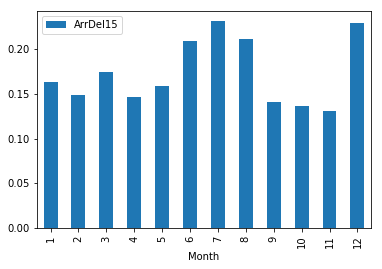

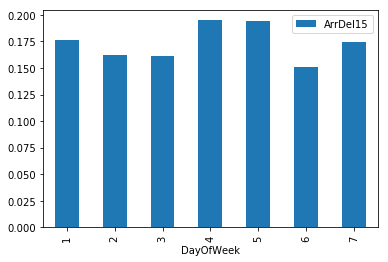

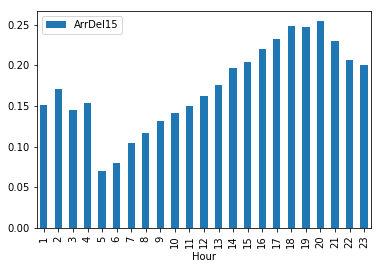

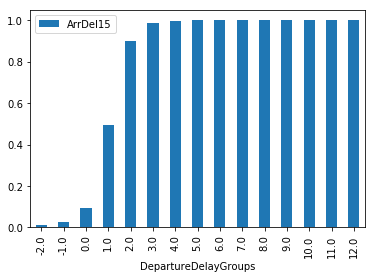

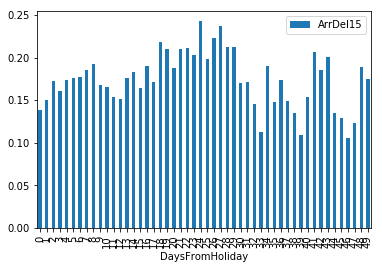

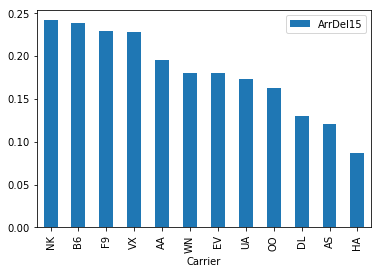

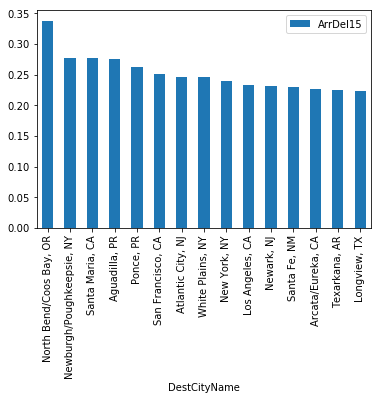

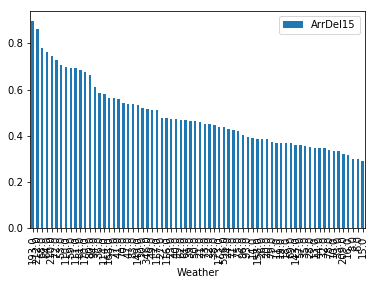

In [64]:
features_mean = ['Month', 'DayOfWeek','Hour', 'DepartureDelayGroups', 'DaysFromHoliday']
features_num = ['Carrier', 'DestCityName', 'Weather']

for f in features_mean:
    grouped = df[['ArrDel15', f]].groupby(f).mean()
    grouped.plot(kind='bar')
for f in features_num:
    # Compute average number of delayed flights per carrier
    grouped1 = df[['ArrDel15', f]].groupby(f).filter(lambda x: len(x)>10)
    grouped2 = grouped1.groupby(f).mean()
    final = grouped2.sort_values(['ArrDel15'], ascending=False)

    # display top 15 destination carriers by delay (from ORD)
    final[:15].plot(kind='bar')


### 4. Data Modeling


In [74]:
features = ['Month', 'DayOfWeek','Hour', 'DepartureDelayGroups', 'DaysFromHoliday', 'Carrier', 'Dest', 'Weather', 'Distance', 'Diverted']
label = 'ArrDel15'
X = pd.get_dummies(df[features])
Y = np_utils.to_categorical(df[label])

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.75, random_state=1234)

In [77]:
xtrain = xtrain.as_matrix()
xtest = xtest.as_matrix()

#### 4.1 Neural Network

In [ ]:
from keras.regularizers import l1
model = Sequential()

model.add(Dense(10, input_shape=(xtrain.shape[1],), W_regularizer=l1(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

sgd = SGD(lr=0.1)

model.compile(loss='hinge', optimizer='Adagrad')
model.fit(xtrain, ytrain, validation_split=0.2, batch_size=500000, nb_epoch=5)

/Users/apple/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_shape=(330,), kernel_regularizer=<keras.reg...)`
/Users/apple/anaconda/lib/python3.6/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3322886 samples, validate on 830722 samples
Epoch 1/5


#### 4.1 Random Forest

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# clf_rf.fit(xtrain.toarray(), ytrain)

# Evaluate on test set
pr = clf_rf.predict(xtest.toarray())

# print results
cm = confusion_matrix(ytest, pr)
print("Confusion matrix")
print(pd.DataFrame(cm))
report_rf = precision_recall_fscore_support(list(ytest), list(pr), average='micro')
print "precision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], accuracy_score(list(ytest), list(pr)))